# precomputing 

In [1]:
ROOT = '/var/www/dav/xg590/github/retrosim/'
import pickle, sys, os, time 
if not os.path.isfile(ROOT + 'data.pkl'): 
    sys.path.append(ROOT)
    from retrosim.utils.generate_retro_templates import process_an_example 
    from rdchiral.main import rdchiralReaction 
    import rdkit.Chem as Chem
    import rdkit.Chem.AllChem as AllChem 
    import pandas as pd 
    
    print('It takes me 15 min to finish')
    getfp = lambda smi: AllChem.GetMorganFingerprint(Chem.MolFromSmiles(smi), 2, useFeatures=True)
    start_time = time.time()
    data = pd.read_csv(ROOT + 'retrosim/data/data_processed.csv') 
    del data['Unnamed: 0'], data['class'], data['prod_smiles_pop'], data['keep'] 
    data['prod_fp'] = [getfp(smi) for smi in data['prod_smiles']] 
    data['rcts_ref_fp'] = [getfp(rxn_smiles.split('>')[0]) for rxn_smiles in data['rxn_smiles']]
    templates = ['(' + process_an_example(rxn_smiles, super_general=True).replace('>>', ')>>') for rxn_smiles in data['rxn_smiles']]
    data['rxn'] = [rdchiralReaction(template) for template in templates] # two additional methods 
    [i.deleteUnpicklableAttributes() for i in data['rxn']] # delete attribues for Pickling
    print('Finished in {:.3f} seconds'.format(time.time() - start_time))
    
    with open('data.pkl', 'wb') as f:
        pickle.dump(data, f)

It takes me 15 min to finish
Finished in 906.174 seconds


# Based on ../retrosim/retrosim/scripts/usable_model.ipynb 

In [2]:
from rdkit import DataStructs
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem 
from rdkit.Chem.Draw import MolsToGridImage, IPythonConsole 
IPythonConsole.ipython_useSVG=True 
import os, sys, time, pickle
import numpy as np
from rdchiral.main import rdchiralRun, rdchiralReactants 

class getPrecursors:
    def __init__(self):  
        # load precedents 
        print('Loading... (over 20 seconds)') 
        start_time = time.time()
        with open(ROOT + 'data.pkl', 'rb') as f:
            self.data = pickle.load(f)  
        [i.addUnpicklableAttributes() for i in self.data['rxn']]
        print('Finished in {:.3f} seconds'.format(time.time() - start_time))
        # Choose algorithms
        self.similarity_metric = DataStructs.BulkTanimotoSimilarity # BulkDiceSimilarity or BulkTanimotoSimilarity 
        self.getfp = lambda smi: AllChem.GetMorganFingerprint(Chem.MolFromSmiles(smi), 2, useFeatures=True) 
        
    def wantedReactant(self, smarts):  
        self.wantedReactants = [Chem.MolFromSmarts(sma) for sma in smarts]
        
    def hasWantedReactant(self, predictedReactant): 
        predictedReactants = [Chem.MolFromSmiles(i) for i in predictedReactant.split('.')]
        for predictedReactant in predictedReactants:
            for wantedReactant in self.wantedReactants:
                if predictedReactant.HasSubstructMatch(wantedReactant):
                    return True
        return False 
    
    def run(self, xtnl_smiles, prod_limit = 100, rect_limit = 50):  
        start_time = time.time()
        xtnl_mol = Chem.MolFromSmiles(xtnl_smiles) # Mol of product 
        display(xtnl_mol) # draw product
        xtnl_rct = rdchiralReactants(xtnl_smiles) # use product to initialize reaction 
        xtnl_fp = self.getfp(xtnl_smiles) # fingerprint of product
        xtnl_sims = self.similarity_metric(xtnl_fp, [fp_ for fp_ in self.data['prod_fp']]) # similarity of precedent product against target product
        # Get probability of precursors
        probs = {}   
        limitReactant = hasattr(self, 'wantedReactants')
        js = np.argsort(xtnl_sims)[-1:-1 - prod_limit:-1]  # index of precedent reaction with its product having top 100 similarity against target product
        #return 
        for j in js:
            #continue
            xtnl_prod_sim = xtnl_sims[j] # product similarity of precedent reaction
            try:
                outcomes = rdchiralRun(self.data['rxn'][j], xtnl_rct, combine_enantiomers=False) # break the bond according to the template 
                if limitReactant: 
                    outcomes = [i for i in outcomes if i.find('.')>-1 and self.hasWantedReactant(i)] #  Single Reactant is excluded  
            except Exception as e:
                print(e)
                outcomes = [] 
            for precursors in outcomes: # retrosynthetic reactants 
                precursors_fp = self.getfp(precursors)
                precursors_sim = self.similarity_metric(precursors_fp, [self.data['rcts_ref_fp'][j]])[0] # similarity between precedent reactants and retrosynthetic one  
                if precursors in probs:
                    probs[precursors] = max(probs[precursors], precursors_sim * xtnl_prod_sim) # final scores
                else:
                    probs[precursors] = precursors_sim * xtnl_prod_sim  
        print('took {:.3f} seconds to apply <= 100 templates'.format(time.time() - start_time))
        if not probs:
            print('No Reactants can be recovered! ')
            return None
        mols = []
        legends = [] 
        limitedProcedents = sorted(probs.items(), key=lambda x:x[1], reverse=True)[:rect_limit]
        for i, (prec, prob) in enumerate(limitedProcedents):
            mols.append(Chem.MolFromSmiles(prec)) # smiles of retrosynthetic reactant to mol 
            legends.append('#{} : {:.3f}'.format(i, prob)) #    
        img = MolsToGridImage(mols[:9],molsPerRow=3,subImgSize=(300,300),legends=legends[:9]) 
        display(img) 
        return [Chem.MolToSmiles(x, True) for x in mols] # mol to smiles 

# Instantialize the class and test retrosynthesis on a product 

In [3]:
runner = getPrecursors() 

Loading... (over 20 seconds)
Finished in 20.789 seconds


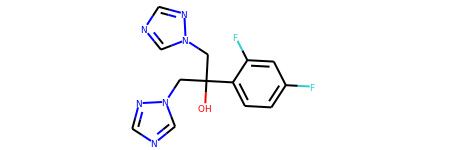

took 0.227 seconds to apply <= 100 templates


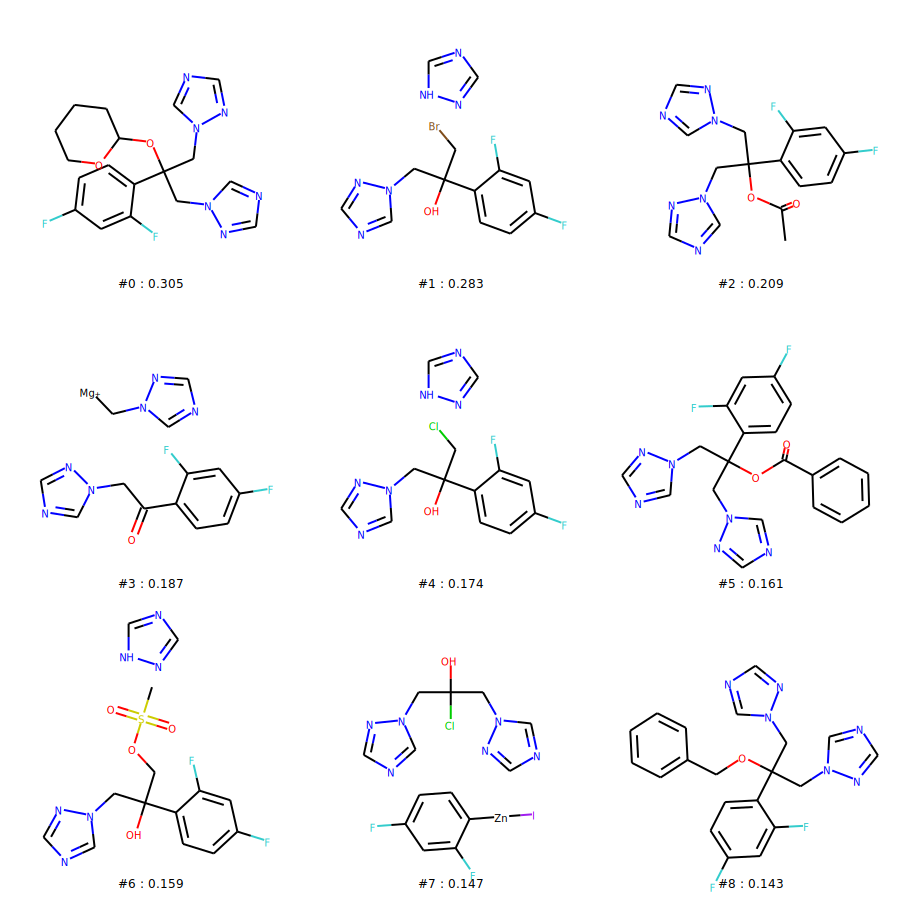

In [4]:
smiles = runner.run('OC(Cn1cncn1)(Cn1cncn1)c1ccc(F)cc1F')

# Parameters can be configured to search more extensively. 

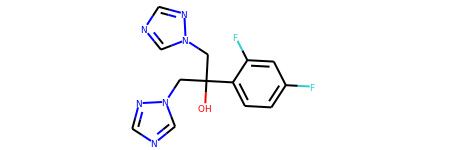

took 1.182 seconds to apply <= 100 templates


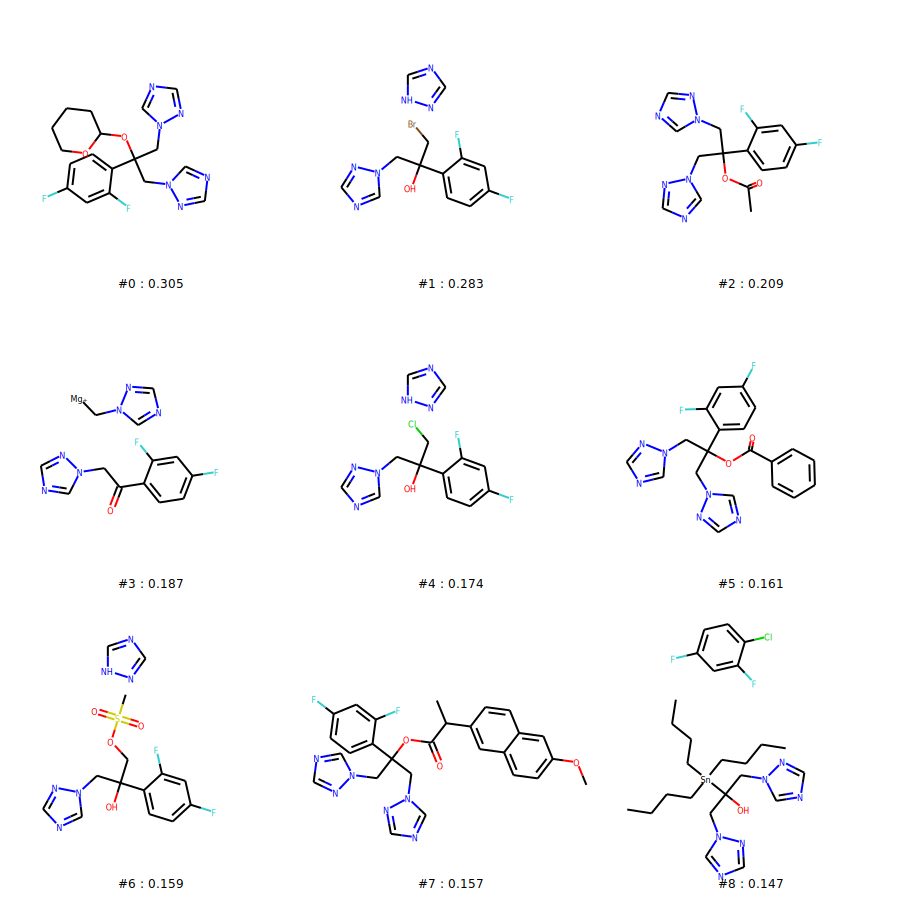

In [5]:
smiles = runner.run('OC(Cn1cncn1)(Cn1cncn1)c1ccc(F)cc1F', prod_limit = 1000, rect_limit = 50)

## #7 has a higher overall score than that in the last run

# Reactant can be specified

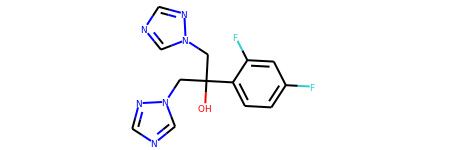

took 1.115 seconds to apply <= 100 templates


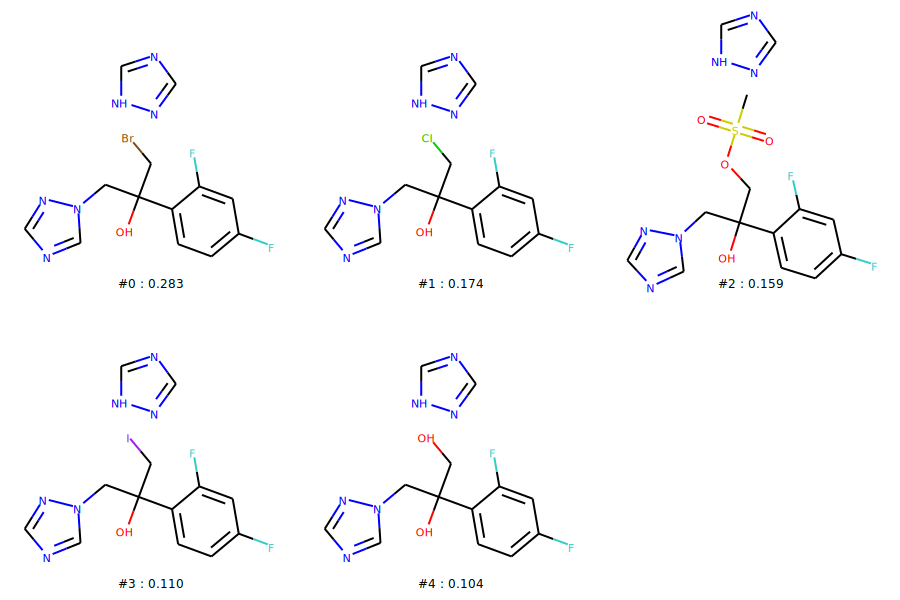

In [6]:
triazole = ['c1nc[nH]n1'] 
runner.wantedReactant(triazole)
smiles = runner.run('OC(Cn1cncn1)(Cn1cncn1)c1ccc(F)cc1F', prod_limit = 1000, rect_limit = 50) 